
## First Step: Data Loading

We need to load TAVG data from the weather dataset. 
* The parquet file is ../../../weather_data/weather_1950_2025_combined.parquet
* We want to load years 1950-2025 of TAVG for all available stations
* The data should be in wide format with daily temperature values for each station-year combination.


In [1]:
import dask.dataframe as dd
# Load TAVG data for all available years (1950-2025)
weather_data_all_years = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet')
tavg_data = weather_data_all_years[weather_data_all_years['ELEMENT'] == 'TAVG'].compute()

print(f"Loaded {len(tavg_data)} TAVG records for all years")
print(f"Years: {sorted(tavg_data['year'].unique())}")
print(f"Stations: {tavg_data['ID'].nunique()}")


Loaded 295949 TAVG records for all years
Years: [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023, 2024, 2025]
Stations: 9449


In [2]:
import dask.dataframe as dd
# Load all available years of TAVG data
tavg_data = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet').query(
    "ELEMENT == 'TAVG'"
).compute()

print(f"Loaded {len(tavg_data)} TAVG records (all years)")
print(f"Years: {sorted(tavg_data['year'].unique())}")
print(f"Stations: {tavg_data['ID'].nunique()}")



Loaded 295949 TAVG records (all years)
Years: [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023, 2024, 2025]
Stations: 9449


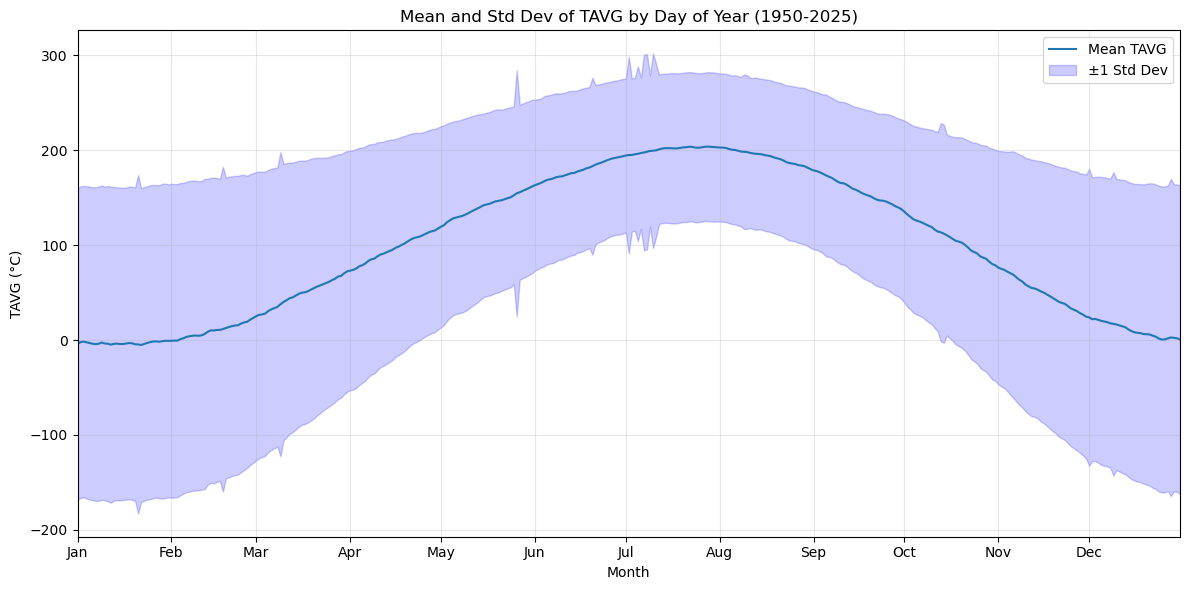

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Select columns for each day of the year (assuming columns named day_1 to day_365)
day_cols = [col for col in tavg_data.columns if col.startswith('day_') and col[4:].isdigit()]
day_cols_sorted = sorted(day_cols, key=lambda x: int(x.split('_')[1]))

# Calculate mean and std for each day of year across all stations/years
daily_means = tavg_data[day_cols_sorted].mean()
daily_stds = tavg_data[day_cols_sorted].std()

days = np.arange(1, len(day_cols_sorted)+1)

plt.figure(figsize=(12,6))
plt.plot(days, daily_means, label='Mean TAVG')
plt.fill_between(days, daily_means-daily_stds, daily_means+daily_stds, color='b', alpha=0.2, label='±1 Std Dev')

# Define month boundaries for labels (non-leap year)
month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

plt.xticks(month_boundaries, month_labels)
plt.xlim(1, 365)
plt.xlabel('Month')
plt.ylabel('TAVG (°C)')
plt.title('Mean and Std Dev of TAVG by Day of Year (1950-2025)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [4]:
import dask.dataframe as dd

stations_df = dd.read_parquet("../weather_info/stations_dask.parquet")


In [5]:
print("stations_df columns:", stations_df.columns)
print("tavg_data columns:", tavg_data.columns)


stations_df columns: Index(['station_id', 'latitude', 'longitude', 'elevation', 'state', 'name',
       'gsn_flag', 'hcn_crn_flag', 'wmo_id'],
      dtype='object')
tavg_data columns: Index(['ID', 'year', 'ELEMENT', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_7',
       ...
       'day_356', 'day_357', 'day_358', 'day_359', 'day_360', 'day_361',
       'day_362', 'day_363', 'day_364', 'day_365'],
      dtype='object', length=368)


In [6]:
# Join stations_df (Dask DataFrame) and tavg_data (assumed pandas DataFrame) on station_id <-> ID
joined_df = stations_df.merge(tavg_data, left_on='station_id', right_on='ID', how='inner')



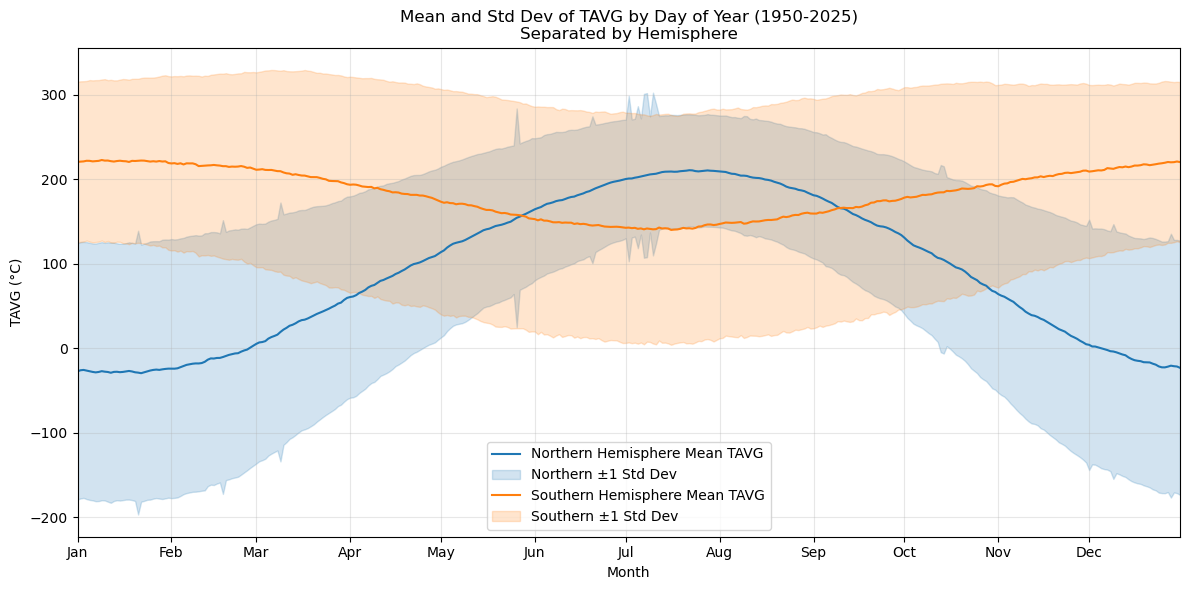

In [7]:
import matplotlib.pyplot as plt

# Compute hemisphere for each station based on latitude
joined_df['hemisphere'] = joined_df['latitude'].map(lambda lat: 'Northern' if lat >= 0 else 'Southern', meta=('latitude', 'object'))

# Calculate daily means and stds for each hemisphere
day_cols = [f'day_{i}' for i in range(1, 366)]
northern_data = joined_df[joined_df['hemisphere'] == 'Northern'][day_cols].compute()
southern_data = joined_df[joined_df['hemisphere'] == 'Southern'][day_cols].compute()

northern_means = northern_data.mean()
northern_stds = northern_data.std()
southern_means = southern_data.mean()
southern_stds = southern_data.std()

# Plot
plt.figure(figsize=(12, 6))
days = range(1, 366)

# Northern Hemisphere
plt.plot(days, northern_means, label='Northern Hemisphere Mean TAVG', color='tab:blue')
plt.fill_between(days, northern_means-northern_stds, northern_means+northern_stds, 
                 color='tab:blue', alpha=0.2, label='Northern ±1 Std Dev')

# Southern Hemisphere
plt.plot(days, southern_means, label='Southern Hemisphere Mean TAVG', color='tab:orange')
plt.fill_between(days, southern_means-southern_stds, southern_means+southern_stds, 
                 color='tab:orange', alpha=0.2, label='Southern ±1 Std Dev')

# Same xticks as above
month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
plt.xticks(month_boundaries, month_labels)
plt.xlim(1, 365)
plt.xlabel('Month')
plt.ylabel('TAVG (°C)')
plt.title('Mean and Std Dev of TAVG by Day of Year (1950-2025)\nSeparated by Hemisphere')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


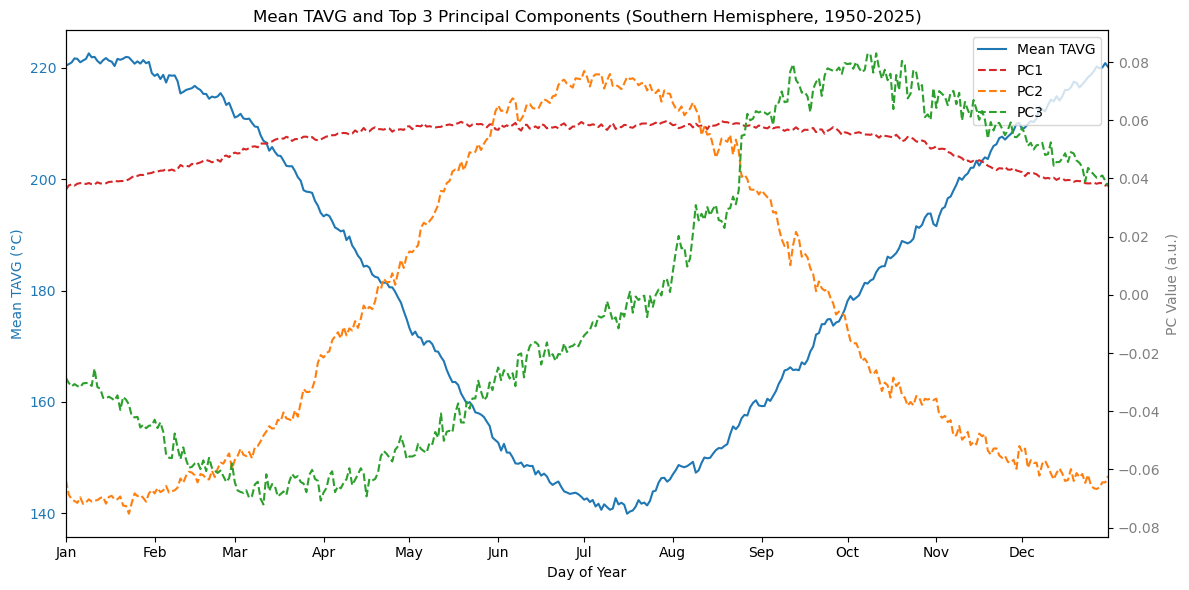

In [23]:
# Use dask_pca to compute and plot the mean and top 3 eigenvectors for southern_data

# Import dask_pca and related functions (assume dask_pca.py is available in path)
from dask_pca import dask_pca

# Run PCA on southern_data - keep top 3 components
# southern_data shape: (n_stations, 365), rows are stations, columns are days
import numpy as np
import dask.array as da

# Convert the pandas DataFrame southern_data to a dask array for PCA
southern_data_arr = da.from_array(southern_data.values, chunks=(128, -1))

# dask_pca returns: components_, explained_variances_, mean_
components, explained_variances, mean = dask_pca(southern_data_arr, n_components=3)

import matplotlib.pyplot as plt

# Compute results (force computation)
mean_np = mean        # (365,)
components_np = components   # (3, 365)

days = np.arange(1, 366)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the mean TAVG
mean_line, = ax1.plot(days, mean_np, color='tab:blue', label='Mean TAVG')
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Mean TAVG (°C)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Mark the PC lines in other colors, with a second y-axis
ax2 = ax1.twinx()
pc_colors = ['tab:red', 'tab:orange', 'tab:green']
pc_labels = [f'PC{i+1}' for i in range(3)]
pc_lines = []
for i in range(3):
    line, = ax2.plot(days, components_np[i], color=pc_colors[i], label=pc_labels[i], linestyle='--')
    pc_lines.append(line)

ax2.set_ylabel('PC Value (a.u.)', color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

# Add legends for both axes
lines = [mean_line] + pc_lines
labels = ['Mean TAVG'] + pc_labels
ax1.legend(lines, labels, loc='upper right')

# Format x axis
month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
plt.xticks(month_boundaries, month_labels)
plt.xlim(1, 365)
plt.title('Mean TAVG and Top 3 Principal Components (Southern Hemisphere, 1950-2025)')
plt.tight_layout()
plt.show()
